In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

from itertools import product
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.naive_bayes import GaussianNB # Import Naive Bayes Classifier
from sklearn.svm import SVC, LinearSVC # Import SVM Classifier
from sklearn.neighbors import KNeighborsClassifier # Import KNN Classifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
from pprint import pprint
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from prettytable import PrettyTable
from scipy import stats
from matplotlib.pyplot import pie, axis, show
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel, RFE
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
# https://github.com/caiocarneloz/masksemi
from masksemi.masksemi import maskData
# https://www.kaggle.com/semisupervised/semi-supervised-sklearn

from helpers import Trainer, plot_conf_mat, plot_roc, plot_roc_avg, plot_pie_chart, stats_test

random.seed(0)

In [11]:
data = pd.read_csv('dataset_diabetes/diabetic_data.csv', sep=',')

print('Number of records:', data.shape[0], 'Number of features:', data.shape[1])

Number of records: 101766 Number of features: 50


In [12]:
t = PrettyTable(['Feature', 'Number of Unique Elements'])
# list the unique elements in columns
for col in data.columns:
    t.add_row([col, len(data[col].unique())])
print(t)

+--------------------------+---------------------------+
|         Feature          | Number of Unique Elements |
+--------------------------+---------------------------+
|       encounter_id       |           101766          |
|       patient_nbr        |           71518           |
|           race           |             6             |
|          gender          |             3             |
|           age            |             10            |
|          weight          |             10            |
|    admission_type_id     |             8             |
| discharge_disposition_id |             26            |
|   admission_source_id    |             17            |
|     time_in_hospital     |             14            |
|        payer_code        |             18            |
|    medical_specialty     |             73            |
|    num_lab_procedures    |            118            |
|      num_procedures      |             7             |
|     num_medications      |   

In [4]:
data.replace(to_replace="Unknown/Invalid", value=np.nan, inplace=True)
data.replace(to_replace="?", value=np.nan, inplace=True)
# print('---Replacing ? -> np.nan')
data = data[data['diag_1'].notna()]
data = data[data['diag_2'].notna()]
data = data[data['diag_3'].notna()]
data = data[data['race'].notna()]
# print('---Removing rows where diag_1, diag_2, diag_3, race are missing')

print('Percentage (%) of Missing values in each feature')
print('--------------------------------------------')
print(np.round(data.isnull().sum()[data.isnull().sum()>0] / len(data) * 100, 1))
print('--------------------------------------------')
print('--------------------------------------------')

Percentage (%) of Missing values in each feature
--------------------------------------------
gender                0.0
weight               96.9
payer_code           39.7
medical_specialty    49.3
dtype: float64
--------------------------------------------
--------------------------------------------


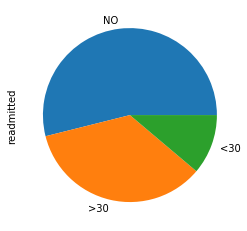

In [15]:
data['readmitted'].value_counts().plot.pie()
# print(data['readmitted'].unique())
# plot_pie_chart(['No', '>30', '<30'][::-1], data['readmitted'], '')

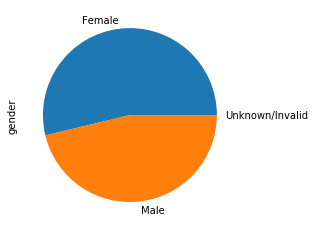

In [16]:
data['gender'].value_counts().plot.pie()
# print(data['gender'].unique())
# plot_pie_chart(['Female', 'Male'], data['gender'], '')

In [17]:
del data['weight'], data['payer_code'], data['encounter_id'], data['patient_nbr']
print('---Removing columns weight, payer_code, encounter_id, patient_nbr')

#     data['readmitted'].value_counts().plot.pie()
#     data['gender'].value_counts().plot.pie()

col_names = data.columns

data.diag_1 = data.diag_1.astype(str)
data.diag_2 = data.diag_2.astype(str)
data.diag_3 = data.diag_3.astype(str)
diag_dict = {}
# Circulatory
diag_dict[785] = 'Circulatory'
for i in range(390, 459):
    diag_dict[i] = 'Circulatory'
# Respiratory
diag_dict[786] = 'Respiratory'
for i in range(460, 519):
    diag_dict[i] = 'Respiratory'
# Digestive
diag_dict[787] = 'Digestive'
for i in range(520, 579):
    diag_dict[i] = 'Digestive'
# Injury
for i in range(800, 999):
    diag_dict[i] = 'Injury'
# Musculoskeletal
for i in range(710, 739):
    diag_dict[i] = 'Musculoskeletal'
# Genitourinary
for i in range(580, 629):
    diag_dict[i] = 'Genitourinary'
# Neoplasms
diag_dict[780] = 'Neoplasms'
diag_dict[781] = 'Neoplasms'
diag_dict[782] = 'Neoplasms'
diag_dict[784] = 'Neoplasms'
for i in range(140, 239):
    diag_dict[i] = 'Neoplasms'
for i in range(790, 799):
    diag_dict[i] = 'Neoplasms'
for i in range(240, 279):
    if i is 250:
        continue
    diag_dict[i] = 'Neoplasms'
for i in range(680, 709):
    diag_dict[i] = 'Neoplasms'
# Diabetes
for i in data.diag_1:
    if i.startswith("250"):
        diag_dict[i] = 'Diabetes'
for i in data.diag_1:
    if i not in diag_dict:
        diag_dict[i] = 'Other'

final_dict = {}
for k, v in diag_dict.items():
    final_dict[str(k)] = v

final_dict = pd.Series(final_dict)
data.diag_1 = data.diag_1.map(final_dict)
data.diag_2 = data.diag_2.map(final_dict)
data.diag_3 = data.diag_3.map(final_dict)
# print(len(data.diag_1.unique()))
# print(len(data.diag_2.unique()))
# print(len(data.diag_3.unique()))

---Removing columns weight, payer_code, encounter_id, patient_nbr


In [20]:
# label encoding for only columns with categorical data
data.replace(to_replace=np.nan, value='?', inplace=True)
for col in data.columns:
    if col not in ['time_in_hospital', 
                   'num_lab_procedures', 
                   'num_procedures', 
                   'num_medications', 
                   'number_outpatient', 
                   'number_emergency', 
                   'number_inpatient', 
                   'number_diagnoses']:
        unique_elem = sorted(data[col].unique())
        if '?' in unique_elem:
            unique_elem = unique_elem[1:]
        data[col].replace(unique_elem, list(range(len(unique_elem))), inplace=True)
data.replace(to_replace='?', value=np.nan, inplace=True)
print('---Transform nominal data to categorical')

---Transform nominal data to categorical


In [9]:
data.shape

(98053, 46)

In [ ]:
imputed_data = IterativeImputer(max_iter=100, random_state=0, initial_strategy='most_frequent').fit_transform(data.to_numpy())
# imputed_data = SimpleImputer(strategy='most_frequent').fit_transform(data.to_numpy())
data = pd.DataFrame.from_records(imputed_data)
data.columns = col_names
print('---Imputing missing values')

In [21]:
ids = data.columns[:-1]
data[ids] = (data[ids] - data[ids].mean()) / (data[ids].std() + 1e-4)
print('---Standarizing data')

---Standarizing data
